<a href="https://colab.research.google.com/github/SisekoC/OpenCV/blob/main/colab_demo_free_tier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visual Anagrams: Generating Multi-View Optical Illusions with Diffusion Models

**Originally authored by: [Tamizh N](https://github.com/tmzh)** (with changes by: [Daniel Geng](https://dangeng.github.io/))

This colab notebook generates [visual anagrams and other multi-view optical illusions](https://dangeng.github.io/visual_anagrams/) on <font color='orange'>**memory-constrained systems**</font> (such as free-tier Colab T4 GPUs). The code is based on the original [project notebook](https://colab.research.google.com/github/dangeng/visual_anagrams/blob/main/notebooks/colab_demo_pro_tier.ipynb), which requires a Colab Pro subscription for enough resources to run (but is a bit more convenient to use).

In order to fit everything in a low memory setting, we:
- First load the T5 text encoder, to generate prompt embeddings
- Delete the T5 encoder and flush the memory
- Load in the DeepFloyd IF image generation models and generate visual anagrams using the prompt embeddings
- Additionally, we use `float16` precision and and [large model inference support with `accelerate`](https://huggingface.co/docs/accelerate/usage_guides/big_modeling)

Using this approach, we can generate samples using colab free-tier resources, with the drawback that we need to reload the T5 encoder (and delete the DeepFloyd image generation models) every time we want to try new prompts. Although this drawback can be mitigated to some extent by encoding all the prompts we want to use before deleting the T5 encoder.

By the way, if you generate a particularly good illusion, please send it our way! We'd love to feature it on our website.

## DeepFloyd Access

Our method uses [DeepFloyd IF](https://huggingface.co/docs/diffusers/api/pipelines/deepfloyd_if), a pixel-based diffusion model. We do not use Stable Diffusion because latent diffusion models cause artifacts in illusions (see our paper for more details).

Before using DeepFloyd IF, you must accept its usage conditions. To do so:

1. Make sure to have a [Hugging Face account](https://huggingface.co/join) and be logged in.
2. Accept the license on the model card of [DeepFloyd/IF-I-XL-v1.0](https://huggingface.co/DeepFloyd/IF-I-XL-v1.0). Accepting the license on the stage I model card will auto accept for the other IF models.
3. Log in locally by entering your [Hugging Face Hub access token](https://huggingface.co/docs/hub/security-tokens#what-are-user-access-tokens) below, which can be [found here](https://huggingface.co/settings/tokens).

In [3]:
from huggingface_hub import login

login()

## Install Dependencies

Run the below to install dependencies, including [the `visual_anagrams` repo](https://github.com/dangeng/VisualAnagrams_prerelease) which will do the heavy lifting.

In [4]:
! pip install -q \
  diffusers \
  transformers \
  safetensors \
  sentencepiece \
  accelerate \
  bitsandbytes \
  einops \
  mediapy \
  accelerate

!pip install -q git+https://github.com/dangeng/visual_anagrams.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Import Dependencies and Misc Setup

We import packages we need and define some useful functions

In [5]:
import gc
import mediapy as mp

import torch
from diffusers import DiffusionPipeline

from visual_anagrams.views import get_views
from visual_anagrams.samplers import sample_stage_1, sample_stage_2
from visual_anagrams.utils import add_args, save_illusion, save_metadata

device = 'cuda'

def im_to_np(im):
  im = (im / 2 + 0.5).clamp(0, 1)
  im = im.detach().cpu().permute(1, 2, 0).numpy()
  im = (im * 255).round().astype("uint8")
  return im


# Garbage collection function to free memory
def flush():
    gc.collect()
    torch.cuda.empty_cache()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## Load T5 TextEncoder Model
We will load the `T5` text model in half-precision (`fp16`), use it to encode some prompts, and then delete it to recover GPU memory. Note that downloading the model may take a minute or two.

If you need to further reduce memory utilization, you can also load `T5` using `8bit` quantization. Transformers directly supports [bitsandbytes](https://huggingface.co/docs/transformers/main/en/main_classes/quantization#load-a-large-model-in-8bit) through the `load_in_8bit` flag:

```python
T5EncoderModel.from_pretrained("DeepFloyd/IF-I-M-v1.0",subfolder="text_encoder", device_map="auto", load_in_8bit=True, variant="8bit")
```


In [7]:
from transformers import T5EncoderModel

text_encoder = T5EncoderModel.from_pretrained(
    "DeepFloyd/IF-I-L-v1.0",
    subfolder="text_encoder",
    device_map="auto",
    variant="fp16",
    torch_dtype=torch.float16,
)

pipe = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-I-L-v1.0",
    text_encoder=text_encoder,  # pass the previously instantiated text encoder
    unet=None                   # do not use a UNet here, as it uses too much memory
)
pipe = pipe.to(device)

text_encoder/config.json:   0%|          | 0.00/741 [00:00<?, ?B/s]

(…)ncoder/model.safetensors.index.fp16.json:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

model.fp16-00001-of-00002.safetensors:   0%|          | 0.00/9.96G [00:00<?, ?B/s]

model.fp16-00002-of-00002.safetensors:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

model_index.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.57k [00:00<?, ?B/s]

watermarker/config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/15.5k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


##  Create Text Embeddings

We can now use the T5 model to embed prompts for our multi-view illusion. It may be a good idea to embed a few prompts that you want to use, given that we will delete the T5 text encoder in the next block. See the commented out code for an example of how to do this.

### The Art of Choosing Prompts

**Choosing prompts for illusions can be fairly tricky and unintuitive**. Many prompts simply won't make for good illusions, because they are too hard. Here are some tips:

- Styles such as "a photo of" tend to be harder as the constraint of realism is fairly difficult (but this doesn't mean they can't work!).
- Conversely, styles such as "an oil painting of" seem to do better because there's more freedom to how it can be depicted and interpreted.
- In a similar vein, subjects that allow for high degrees of flexibility in depiction tend to be good. For example, prompts such as "houseplants" or "wine and cheese" or "a kitchen"
- But be careful the subject is still easily recognizable. Illusions are much better when they are instantly understandable.
- Faces often make for very good "hidden" subjects. This is probably because the human visual system is particularly adept at picking out faces. For example, "an old man" or "marilyn monroe" tend to be good subjects.
- Perhaps a bit evident, but 3 view and 4 view illusions are considerably more difficult to get to work.
- Intuition and reasoning works less often than you would expect. Prompts that you think would work great often work poorly, and vice versa. So exploration is key.

In [8]:
###############################
### Feel free to change me: ###
###############################
prompt_1 = 'painting of a snowy mountain village'
prompt_2 = 'painting of a horse'

# Embed prompts using the T5 model
prompts = [prompt_1, prompt_2]
prompt_embeds = [pipe.encode_prompt(prompt) for prompt in prompts]
prompt_embeds, negative_prompt_embeds = zip(*prompt_embeds)
prompt_embeds = torch.cat(prompt_embeds)
negative_prompt_embeds = torch.cat(negative_prompt_embeds)  # These are just null embeds


######################################
### Optionally embed more prompts, ###
### as we will delete the T5       ###
### encoder in the next block      ###
######################################

#more_prompts = ['another prompt', 'another prompt']
#more_prompt_embeds = [pipe.encode_prompt(prompt) for prompt in more_prompts]
#more_prompt_embeds, _ = zip(*more_prompt_embeds)
#more_prompt_embeds = torch.cat(more_prompt_embeds)

## Delete the Text Encoder

We now delete the text encoder (and the `diffusers` pipeline) and flush to free memory for the DeepFloyd image generation model.

In [9]:
del text_encoder
del pipe
flush()
flush()   # For some reason we need to do this twice

## Main Diffusion Process

With our now released and available GPU memory, we can load the various DeepFloyd IF diffusion models (also at `float16` precision). This may take a minute of two.

In [10]:
from diffusers import DiffusionPipeline

# Load DeepFloyd IF stage I
stage_1 = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-I-L-v1.0",
    text_encoder=None,
    variant="fp16",
    torch_dtype=torch.float16,
)
stage_1.enable_model_cpu_offload()
stage_1.to(device)

# Load DeepFloyd IF stage II
stage_2 = DiffusionPipeline.from_pretrained(
                "DeepFloyd/IF-II-L-v1.0",
                text_encoder=None,
                variant="fp16",
                torch_dtype=torch.float16,
              )
stage_2.enable_model_cpu_offload()
stage_2.to(device)

# Load DeepFloyd IF stage III
# (which is just Stable Diffusion 4x Upscaler)
stage_3 = DiffusionPipeline.from_pretrained(
                "stabilityai/stable-diffusion-x4-upscaler",
                torch_dtype=torch.float16
            )
stage_3.enable_model_cpu_offload()
stage_3 = stage_3.to(device)


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[safety_checker/model.fp16.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors, unet/diffusion_pytorch_model.fp16.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.87G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components tokenizer, text_encoder, unet, scheduler, safety_checker, feature_extractor, watermarker to GPU when needed. To make sure offloading works as expected, you should consider moving the pipeline back to CPU: `pipeline.to('cpu')` or removing the move altogether if you use offloading.


model_index.json:   0%|          | 0.00/692 [00:00<?, ?B/s]


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[safety_checker/model.fp16.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors, unet/diffusion_pytorch_model.fp16.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

(…)_noising_scheduler/scheduler_config.json:   0%|          | 0.00/424 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/2.50k [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

watermarker/config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/15.5k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/2.49G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components tokenizer, text_encoder, unet, scheduler, image_noising_scheduler, safety_checker, feature_extractor, watermarker to GPU when needed. To make sure offloading works as expected, you should consider moving the pipeline back to CPU: `pipeline.to('cpu')` or removing the move altogether if you use offloading.


model_index.json:   0%|          | 0.00/485 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

low_res_scheduler/scheduler_config.json:   0%|          | 0.00/300 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/825 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/348 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/634 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/221M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/982 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components vae, text_encoder, tokenizer, unet, low_res_scheduler, scheduler, safety_checker, watermarker, feature_extractor to GPU when needed. To make sure offloading works as expected, you should consider moving the pipeline back to CPU: `pipeline.to('cpu')` or removing the move altogether if you use offloading.


## Choose an Illusion

To generate an illusion, we need to provide a list of "views," which tell the model how to transform the image. We can get these by passing a list of strings to the `get_views` function. For a list of views and their implementation see the `views.py` file. Views inherit from the `BaseView` class, so you can implement your own views if you want.


In [11]:
# UNCOMMENT ONE OF THESE

# views = get_views(['identity', 'rotate_180'])
views = get_views(['identity', 'rotate_cw'])
# views = get_views(['identity', 'rotate_ccw'])
# views = get_views(['identity', 'flip'])
#views = get_views(['identity', 'negate'])
# views = get_views(['identity', 'skew'])
#views = get_views(['identity', 'patch_permute'])
# views = get_views(['identity', 'pixel_permute'])
# views = get_views(['identity', 'inner_circle'])
# views = get_views(['identity', 'square_hinge'])
# views = get_views(['identity', 'jigsaw'])

## Generate Illusions
Now, we can sample illusions by denoising multiple views at once. The `sample_stage_1` function does this and generates a $64 \times 64$ image. The `sample_stage_2` function upsamples the resulting image while denoising all views, and generates a $256 \times 256$ image.

Finally, `stage_3` simply upsamples the $256 \times 256$ image using a single given text prompt to $1024 \times 1024$, _without_ doing multi-view denoising.

100%|██████████| 30/30 [00:07<00:00,  4.05it/s]



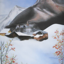
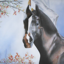

In [12]:
image_64 = sample_stage_1(stage_1,
                          prompt_embeds,      # Replace with different prompts
                          negative_prompt_embeds,
                          views,
                          num_inference_steps=30,
                          guidance_scale=10.0,
                          reduction='mean',
                          generator=None)

# Show result
mp.show_images([im_to_np(view.view(image_64[0])) for view in views])

100%|██████████| 30/30 [00:28<00:00,  1.07it/s]



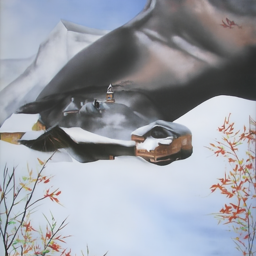
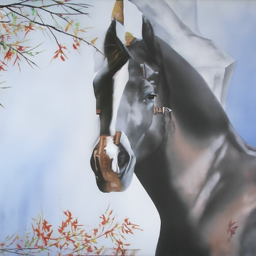

In [13]:
image_256 = sample_stage_2(stage_2,
                           image_64,
                           prompt_embeds,      # Replace with different prompts
                           negative_prompt_embeds,
                           views,
                           num_inference_steps=30,
                           guidance_scale=10.0,
                           reduction='mean',
                           noise_level=50,
                           generator=None)

# Show result
mp.show_images([im_to_np(view.view(image_256[0])) for view in views])

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `vae_latent_channels` directly via 'VaeImageProcessor' object attribute is deprecated. Please access 'vae_latent_channels' over 'VaeImageProcessor's config object instead, e.g. 'scheduler.config.vae_latent_channels'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/usr/local/lib/python3.10/dist-packages/diffusers/image_processor.py:582: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-0.75341796875,0.9296875]
  warnings.warn(


  0%|          | 0/75 [00:00<?, ?it/s]


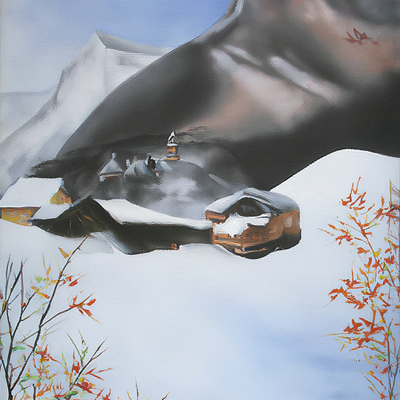
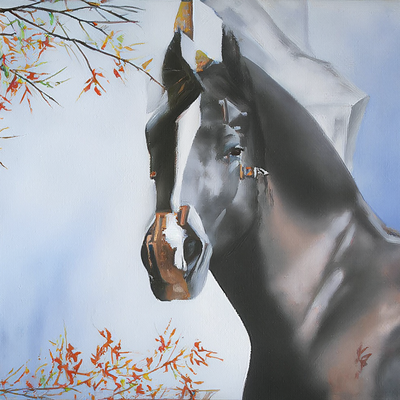

In [14]:
image_1024 = stage_3(
                prompt=prompts[0],  # Note this is a string, and not an embedding
                image=image_256,
                noise_level=0,
                output_type='pt',
                generator=None).images
image_1024 = image_1024 * 2 - 1

# Limit display size, otherwise it's too large for most screens
mp.show_images([im_to_np(view.view(image_1024[0])) for view in views], width=400)

## Animating the Illusion

We will use the `animate_two_view` function to make a video of the illusion. This function takes in a PIL image of the illusion, a `view` object (which should implement `make_frame`), and animates the transformation defined by the `view`. We will save the video to `save_video_path`.

The animation function works for all three sizes: `image_64`, `image_256`, or `image_1024` (thought it takes about a minute for size `1024`).

In [15]:
from visual_anagrams.animate import animate_two_view
import torchvision.transforms.functional as TF

##############################
# UNCOMMENT FOR DESIRED SIZE #
##############################
#image = image_64
#image = image_256
image = image_1024

# Get size
im_size = image.shape[-1]
frame_size = int(im_size * 1.5)

# Make save path
save_video_path = './animation.mp4'

# Convert to PIL
pil_image = TF.to_pil_image(image[0] / 2. + 0.5)

# Make the animation
animate_two_view(
            pil_image,
            views[1], # Use the non-identity view to transform
            prompt_1,
            prompt_2,
            save_video_path=save_video_path,
            hold_duration=120,
            text_fade_duration=10,
            transition_duration=45,
            im_size=im_size,
            frame_size=frame_size,
        )

# Display the video (using max width of 600 so will fit on most screens)
mp.show_video(mp.read_video(save_video_path), fps=30, width=min(600, frame_size))

Making frames...


100%|██████████| 45/45 [00:04<00:00, 10.70it/s]


Making video...


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
